<a href="https://colab.research.google.com/github/asarm/ML_Projects/blob/main/crypto_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/ml_projects

/content/drive/MyDrive/Colab Notebooks/ml_projects


In [135]:
import pandas as pd
import numpy as np
import seaborn
from sklearn import preprocessing
import random
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

In [42]:
PREDICT_PERIOD = 3
SEQ_LEN = 60

In [49]:
def label_class(current,future):
  if current > future:
    return 0
  else:
    return 1

In [252]:
# bitcoin	buy bitcoin	sell bitcoin rows are the google trends data 

df = pd.read_csv('data/train.csv')

df['future_price'] = df['close'].shift(-PREDICT_PERIOD)
df['label'] = list(map(label_class,df['open'], df['future_price']))

df = df.drop(['date','high','low','hourly_chg', 'close'], axis=1)

print(len(df))
print(df['label'].value_counts())
df.head()

5237
1    2682
0    2555
Name: label, dtype: int64


,open,volume,bitcoin,buy bitcoin,sell bitcoin,label,future_price
0,28923.63,2311.811445,6.060473,17.243750,16.277042,1,29278.40
1,28995.13,5403.068471,5.836011,20.378977,22.380932,1,29220.31
2,29410.00,2384.231560,5.611549,20.378977,21.363617,0,29187.01
3,29195.25,1461.345077,5.162626,19.595170,18.311672,0,29174.35
4,29278.41,2038.046803,5.162626,20.378977,16.277042,0,29092.83


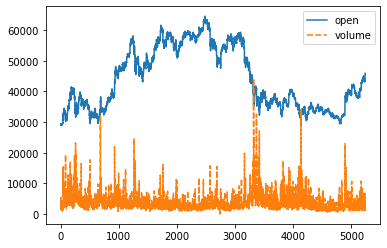

In [20]:
seaborn.lineplot(data=[df['open'], df['volume']])

In [87]:
val_df = df.iloc[int(len(df)*0.85):]
train_df = df.iloc[:int(len(df)*0.85)]

print(len(val_df))
print(len(train_df))
val_df.head(3)

786
4451


,open,volume,bitcoin,buy bitcoin,sell bitcoin,label,future_price
4451,33982.03,2057.821377,16.877738,12.876401,9.034113,0,33960.48
4452,34117.98,2604.753990,17.859002,14.307113,9.742671,0,33690.14
4453,33842.18,1488.432410,17.662749,15.737824,10.274090,1,34042.88


In [220]:
def prepare_df(dataframe):
  for col in dataframe.columns:
    if col != 'label':
      dataframe[col] = dataframe[col].pct_change()
      dataframe.dropna(inplace=True)
      dataframe[col] = preprocessing.scale(dataframe[col].values)
  dataframe.dropna(inplace=True)

  x = dataframe.drop(['label', 'future_price'], axis=1)
  y = dataframe['label']


  return np.array(x), np.array(y)

In [ ]:
train_x, train_y = prepare_df(train_df)
val_x, val_y = prepare_df(val_df)

In [ ]:
from tensorflow.keras.utils import to_categorical

val_x = np.expand_dims(val_x, axis=0)
train_x = np.expand_dims(train_x, axis=0)

val_x = val_x.reshape(val_x.shape[1], val_x.shape[0], -1)
train_x = train_x.reshape(train_x.shape[1], train_x.shape[0],-1)

train_y = to_categorical(train_y, 2)
val_y = to_categorical(val_y, 2)

In [249]:
EPOCHS = 50
BATCH_SIZE = 32
NAME = f"BTC_{PREDICT_PERIOD}hours_{int(time.time())}"

In [214]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=train_x.shape))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128,return_sequences=True, input_shape=train_x.shape))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128, input_shape=train_x.shape))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2,activation='softmax'))

In [250]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 4372, 128)         68608     
_________________________________________________________________
dropout_26 (Dropout)         (None, 4372, 128)         0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 4372, 128)         512       
_________________________________________________________________
lstm_29 (LSTM)               (None, 4372, 128)         131584    
_________________________________________________________________
dropout_27 (Dropout)         (None, 4372, 128)         0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 4372, 128)         512       
_________________________________________________________________
lstm_30 (LSTM)               (None, 128)             

In [ ]:
callback = ModelCheckpoint(f"{NAME}.h5", monitor="val_accuracy", verbose=1, save_best_only=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss="categorical_crossentropy", metrics=['accuracy'])
model.fit(train_x, train_y, epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[callback], validation_data=(val_x, val_y))